# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import torchvision
import torchaudio
import lightgbm as lgb
import xgboost as xgb
import imblearn
import scipy
import statsmodels.api as sm
import openpyxl
import shap
import plotly
import lifelines
import optuna

# Configs

In [3]:
# Atlassian Brand Colours
atlassian_colors = [
    "#0052CC",  # Atlassian Blue (primary)
    "#2684FF",  # Bright Blue
    "#57D9A3",  # Green accent
    "#FFAB00",  # Gold accent
    "#FF5630",  # Red accent
    "#36B37E",  # Secondary green
    "#6554C0"   # Purple accent
]

# Set Global Theme
sns.set_theme(
    style="whitegrid",
    palette=atlassian_colors,
    rc={
        "figure.figsize": (10, 6),
        "axes.titlesize": 18,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "axes.edgecolor": "#DFE1E6",  # Atlassian light gray
        "axes.linewidth": 1.0,
        "axes.facecolor": "white",
        "figure.facecolor": "white"
    }
)

# Import datasets

In [4]:
billing_df = pd.read_csv("../datasets/billing.csv")
events_df = pd.read_csv("../datasets/events.csv")
sessions_df = pd.read_csv("../datasets/sessions.csv")
users_df = pd.read_csv("../datasets/users.csv")

# User Dataset EDA

In [5]:
users_df

,user_id,signup_date,plan_tier,company_size,region,industry,acquisition_channel,is_enterprise,churned_30d,churned_90d,downgraded,expansion_event
0,f94d1824-8742-4000-8b6d-39d70958490b,2024-05-13,free,11-50,EU,software,seo,False,0,0,0,1
1,238bf0af-1f71-45e4-a47d-dcb5db33f71b,2025-04-11,standard,1-10,NaN,education,seo,False,0,0,0,0
2,ccf8fc06-3c86-433c-8867-9cba0fda337b,2024-10-28,free,1-10,APAC,transport,partner,False,0,0,0,1
3,3e39c0ea-ebbf-43bc-abd5-ab92eff6fa10,2024-05-17,standard,200+,APAC,software,partner,False,0,0,0,1
4,9304dcbe-682d-41fa-8bfd-861559f9f58b,2024-04-12,free,1-10,NaN,software,ads,False,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,e7e9d70c-478e-4d57-982a-53c98a175328,2024-09-17,premium,51-200,NaN,retail,partner,True,0,0,0,0
99996,1b74fc26-9c01-4aeb-95db-587abfda6e73,2024-04-29,free,11-50,NaN,finance,partner,False,0,1,0,1
99997,c209e590-7bcc-4aff-b3cd-c9c498491c22,2024-11-24,free,1-10,NaN,transport,seo,False,0,0,0,1
99998,06bde50d-e9b3-4db9-8353-cf0279d0060b,2025-05-01,premium,11-50,APAC,manufacturing,seo,False,0,0,0,0


In [6]:
users_df.shape

(100000, 12)

In [7]:
users_df.columns

Index(['user_id', 'signup_date', 'plan_tier', 'company_size', 'region',
       'industry', 'acquisition_channel', 'is_enterprise', 'churned_30d',
       'churned_90d', 'downgraded', 'expansion_event'],
      dtype='object')

## Users over time

In [8]:
# Find range of signup dates
print(users_df['signup_date'].agg(["min","max"]))

min    2024-02-01
max    2025-06-30
Name: signup_date, dtype: object


In [9]:
users_df["user_id"].nunique()

100000

In [11]:
users_df["signup_date"].nunique()

516

In [18]:
users_df["signup_date"] = pd.to_datetime(users_df["signup_date"])

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_3187/3669620185.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")   # "W" for weekly, "M" for monthly


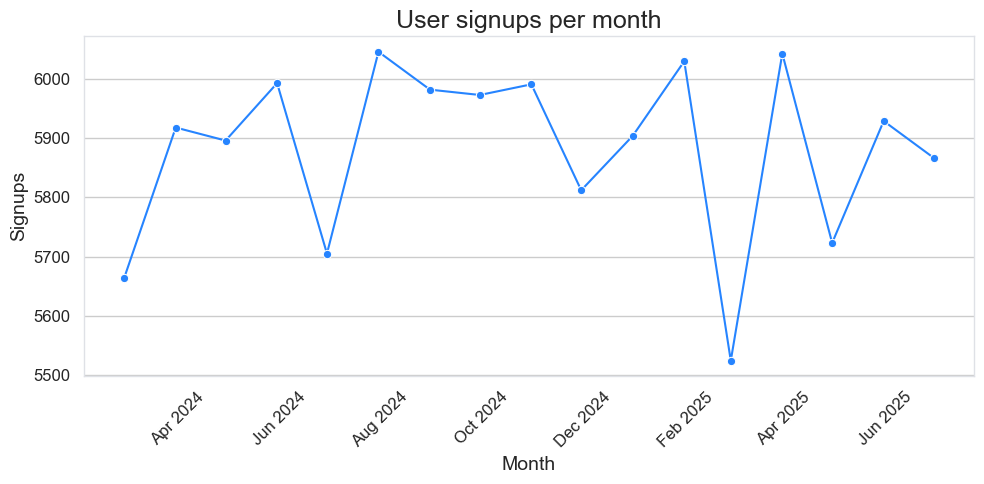

In [25]:
import matplotlib.dates as mdates

# aggregate by month
monthly = (
    users_df.set_index("signup_date")
            .resample("M")   # "W" for weekly, "M" for monthly
            .size()
            .rename("signups")
)

fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(x=monthly.index, y=monthly.values, ax=ax, marker="o", color="#2684FF")

ax.set_title("User signups per month")
ax.set_xlabel("Month")
ax.set_ylabel("Signups")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.grid(False) 
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


Large variance in user signups

## Users by region

In [26]:
# Count total signups by region
region_counts = users_df["region"].value_counts().reset_index()
region_counts.columns = ["region", "signups"]
print(region_counts)

  region  signups
0   APAC    27810
1     EU    25960
2  LATAM     8006


/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_3187/3289232016.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="region", y="signups", data=region_counts, ax=ax, palette="Blues")


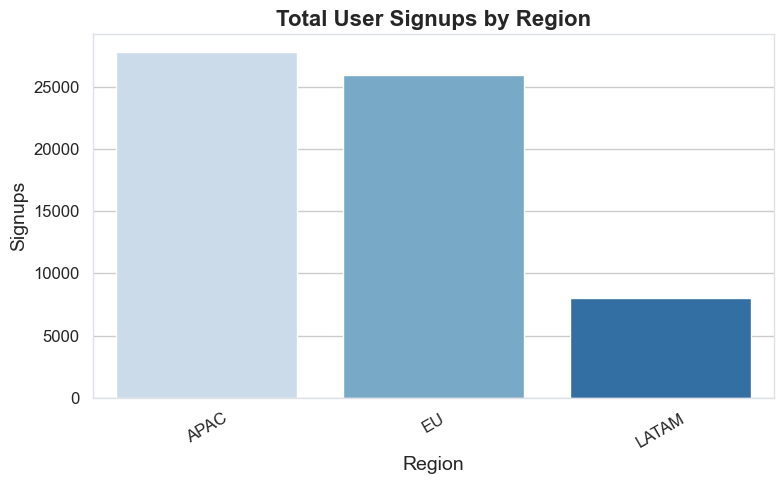

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x="region", y="signups", data=region_counts, ax=ax, palette="Blues")

ax.set_title("Total User Signups by Region", fontsize=16, weight="bold")
ax.set_xlabel("Region")
ax.set_ylabel("Signups")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [37]:
industry_counts = users_df['industry'].value_counts().reset_index()
industry_counts.columns = ["industry", "signups"]
print(industry_counts)


        industry  signups
0      education    10129
1  manufacturing    10126
2     healthcare    10107
3       software    10029
4        finance    10012
5      transport    10010
6          media     9959
7         energy     9941
8        telecom     9852
9         retail     9835


/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_3187/845446022.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="industry", y="signups", data=industry_counts, ax=ax, palette="Blues")


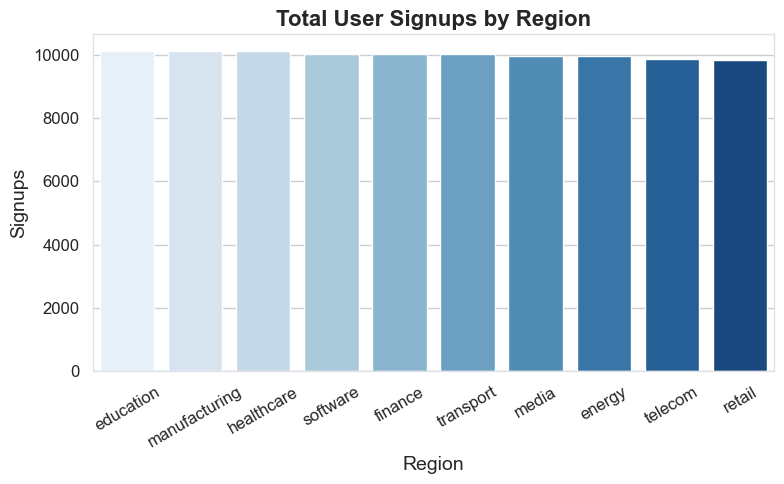

In [39]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x="industry", y="signups", data=industry_counts, ax=ax, palette="Blues")

ax.set_title("Total User Signups by Region", fontsize=16, weight="bold")
ax.set_xlabel("Region")
ax.set_ylabel("Signups")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Seems like all industries have relatively similar usage.  

## Channel

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_3187/659570305.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_counts, x="channel", y="signups", ax=ax, palette="Blues_d")


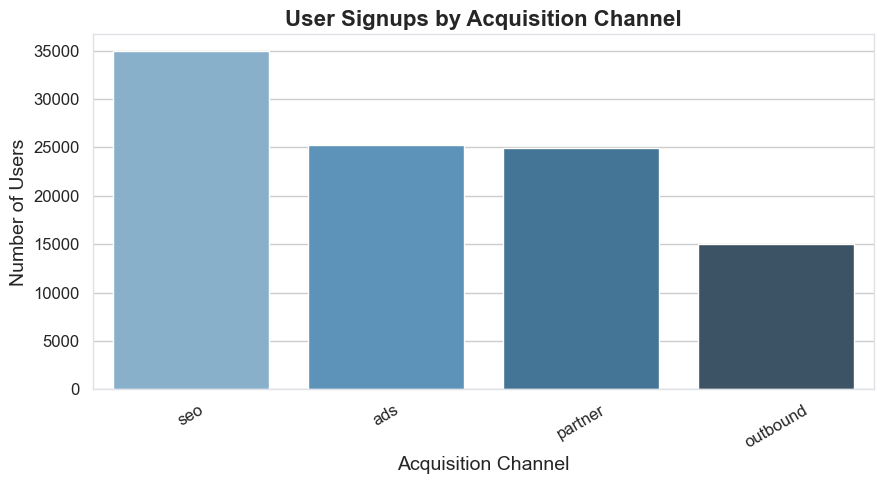

In [41]:
channel_counts = (
    users_df["acquisition_channel"]
    .value_counts()
    .reset_index()
)
channel_counts.columns = ["channel", "signups"]

fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=channel_counts, x="channel", y="signups", ax=ax, palette="Blues_d")

ax.set_title("User Signups by Acquisition Channel", fontsize=16, weight="bold")
ax.set_xlabel("Acquisition Channel")
ax.set_ylabel("Number of Users")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

## Enterprise

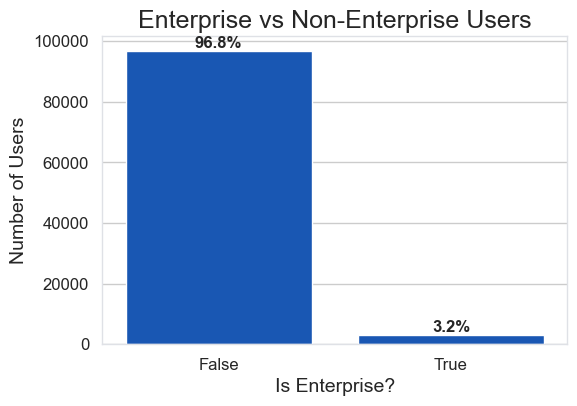

In [49]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=users_df, x="is_enterprise", ax=ax)

# Calculate percentages
total = len(users_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f"{100 * height/total:.1f}%"
    ax.text(
        p.get_x() + p.get_width()/2.,   # x position (center of bar)
        height,                         # y position (top of bar)
        percentage,                     # text
        ha="center", va="bottom", fontsize=12, weight="bold"
    )

ax.set_title("Enterprise vs Non-Enterprise Users")
ax.set_xlabel("Is Enterprise?")
ax.set_ylabel("Number of Users")
plt.show()

## User tier

/var/folders/83/z6dh6x592f7cw62tg8hz97000000gp/T/ipykernel_3187/2631335655.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plan_tier_counts, x="plan_tier", y="signups", ax=ax, palette="Blues_d")


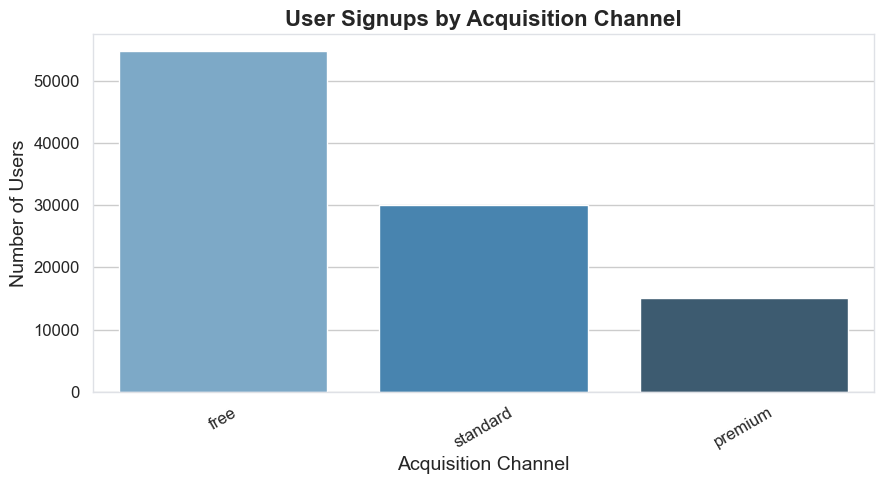

In [ ]:
plan_tier_counts = (
    users_df["plan_tier"]
    .value_counts()
    .reset_index()
)
plan_tier_counts.columns = ["plan_tier", "signups"]

fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(data=plan_tier_counts, x="plan_tier", y="signups", ax=ax, palette="Blues_d")

ax.set_title("User Signups by Plan tier", fontsize=16, weight="bold")
ax.set_xlabel("Plan Tier")
ax.set_ylabel("Number of Users")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

most people are on free tier, mabye understand what makes them upgrade or downgrade

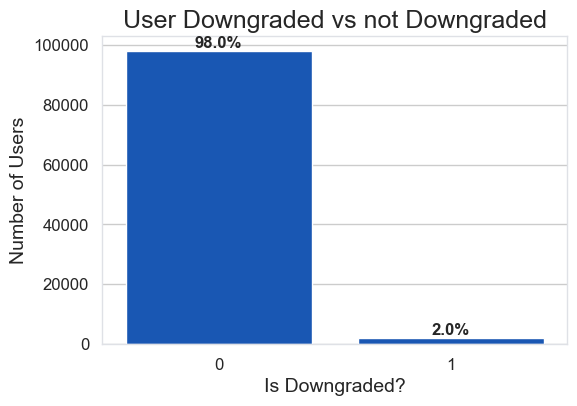

In [66]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=users_df, x="downgraded", ax=ax)

# Calculate percentages
total = len(users_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f"{100 * height/total:.1f}%"
    ax.text(
        p.get_x() + p.get_width()/2.,   # x position (center of bar)
        height,                         # y position (top of bar)
        percentage,                     # text
        ha="center", va="bottom", fontsize=12, weight="bold"
    )

ax.set_title("User Downgraded vs not Downgraded")
ax.set_xlabel("Is Downgraded?")
ax.set_ylabel("Number of Users")
plt.show()

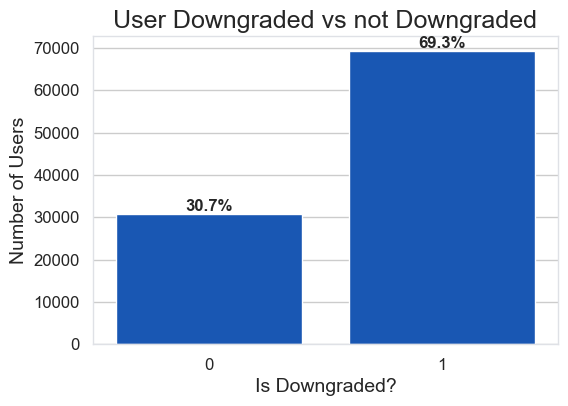

In [67]:
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(data=users_df, x="expansion_event", ax=ax)

# Calculate percentages
total = len(users_df)
for p in ax.patches:
    height = p.get_height()
    percentage = f"{100 * height/total:.1f}%"
    ax.text(
        p.get_x() + p.get_width()/2.,   # x position (center of bar)
        height,                         # y position (top of bar)
        percentage,                     # text
        ha="center", va="bottom", fontsize=12, weight="bold"
    )

ax.set_title("User Downgraded vs not Downgraded")
ax.set_xlabel("Is Downgraded?")
ax.set_ylabel("Number of Users")
plt.show()

# Events Dataset EDA

In [73]:
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234329 entries, 0 to 234328
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   event_id      234329 non-null  object
 1   user_id       234329 non-null  object
 2   session_id    234329 non-null  object
 3   ts            234329 non-null  object
 4   feature_name  234329 non-null  object
 5   action        234329 non-null  object
 6   duration_ms   234329 non-null  int64 
 7   latency_ms    234329 non-null  int64 
 8   success       234329 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 16.1+ MB


In [77]:
events_df.isnull().sum()

event_id        0
user_id         0
session_id      0
ts              0
feature_name    0
action          0
duration_ms     0
latency_ms      0
success         0
dtype: int64

In [76]:
events_df.duplicated().sum()

np.int64(0)

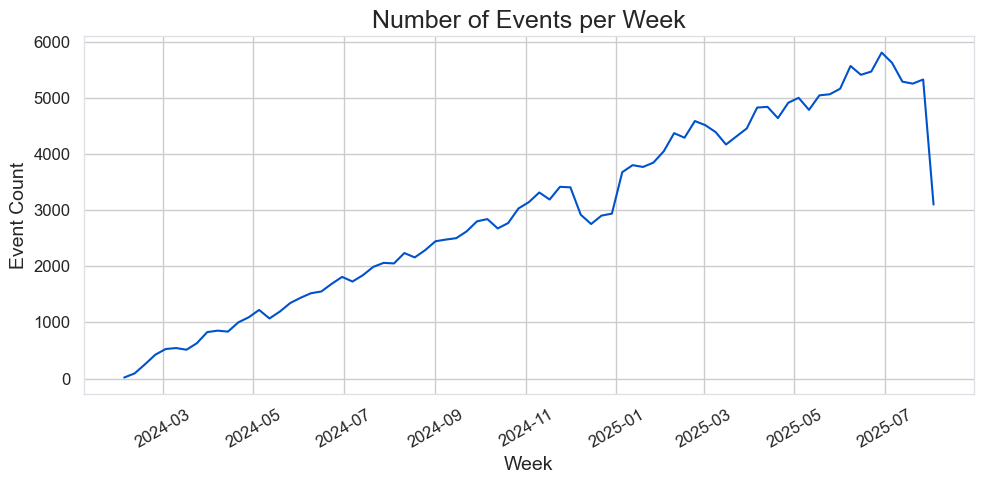

In [88]:
events_df["ts"] = pd.to_datetime(events_df["ts"])

# Per week counts
weekly_counts = (
    events_df.set_index("ts")
    .resample("W")
    .size()
    .reset_index(name="count")
)


fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=weekly_counts, x="ts", y="count", ax=ax)

ax.set_title("Number of Events per Week")
ax.set_xlabel("Week")
ax.set_ylabel("Event Count")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()